In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from data_utils import *
from viz_utils import *
from lstm_obj import lstm


## Sierra Negra
### Training

In [2]:

area_label = 'sierra negra'
central_pixel_x = 500
central_pixel_y = 500
active_range_distance = 120
outer_range_distance = 240

def get_pixel_range(central_pixel: int, distance: int):
    return (central_pixel - distance, central_pixel + distance)

active_range = get_pixel_range(central_pixel_x, active_range_distance), get_pixel_range(central_pixel_y, active_range_distance) # Coordinates of volcano active region
outer_range  = get_pixel_range(central_pixel_x, outer_range_distance), get_pixel_range(central_pixel_y, outer_range_distance) # Width and Height of this region need to be multiple of the grid size used in function "extract_training_data" (grid_size=3 by default)

path = os.path.abspath('./timeseries_demErr.h5')



In [3]:
# Load training data
import pickle
data = pickle.load(open('training_data.p', 'rb'))['sierra negra']

# Build dataset
dataset = build_dataset({'series' : data['series'], 'dates' : data['dates']})
trainset, validset = dataset['train'], dataset['test']

## Train and validate 
lstm_obj = lstm(n_in=trainset['diff'].shape[1]-1, 
                n_out=1, 
                n_feat=trainset['diff'].shape[2],
                n_repeat=2)
lstm_obj.train_and_validate_lstm(trainset['diff'], trainset['raw'],
                                 validset['diff'], validset['raw'])

In [4]:
print (f"Selected Model Rmse Test Set: {lstm_obj.min_rmse}")

## TODO: save model using Keras appropriate function
#pickle.dump({'model' : lstm_obj.model}, open('sierra_negra_model.pickle', 'wb'))

Selected Model Rmse Test Set: 0.03433568083610737


### Inference - Anomaly Maps

In [5]:
# Read data
data, dates = read_data(path)
grid_size=3
time_window=9

assert ((active_range[0][1] - active_range[0][0]) % grid_size == 0)
assert ((active_range[1][1] - active_range[1][0]) % grid_size == 0)

# input to lstm is "diffed"
data_active_raw = crop_volcanodata(data, active_range)
data_active_diff = np.diff(data_active_raw, axis=0) 
data_active_raw = data_active_raw[1:, :, :]
assert (data_active_raw.shape == data_active_diff.shape)

anomaly_map = build_anomaly_map({'raw' : data_active_raw, 'diff' : data_active_diff}, lstm_obj)
print (anomaly_map.shape)

(4, 240, 240)


### Visualizing Anomaly Maps

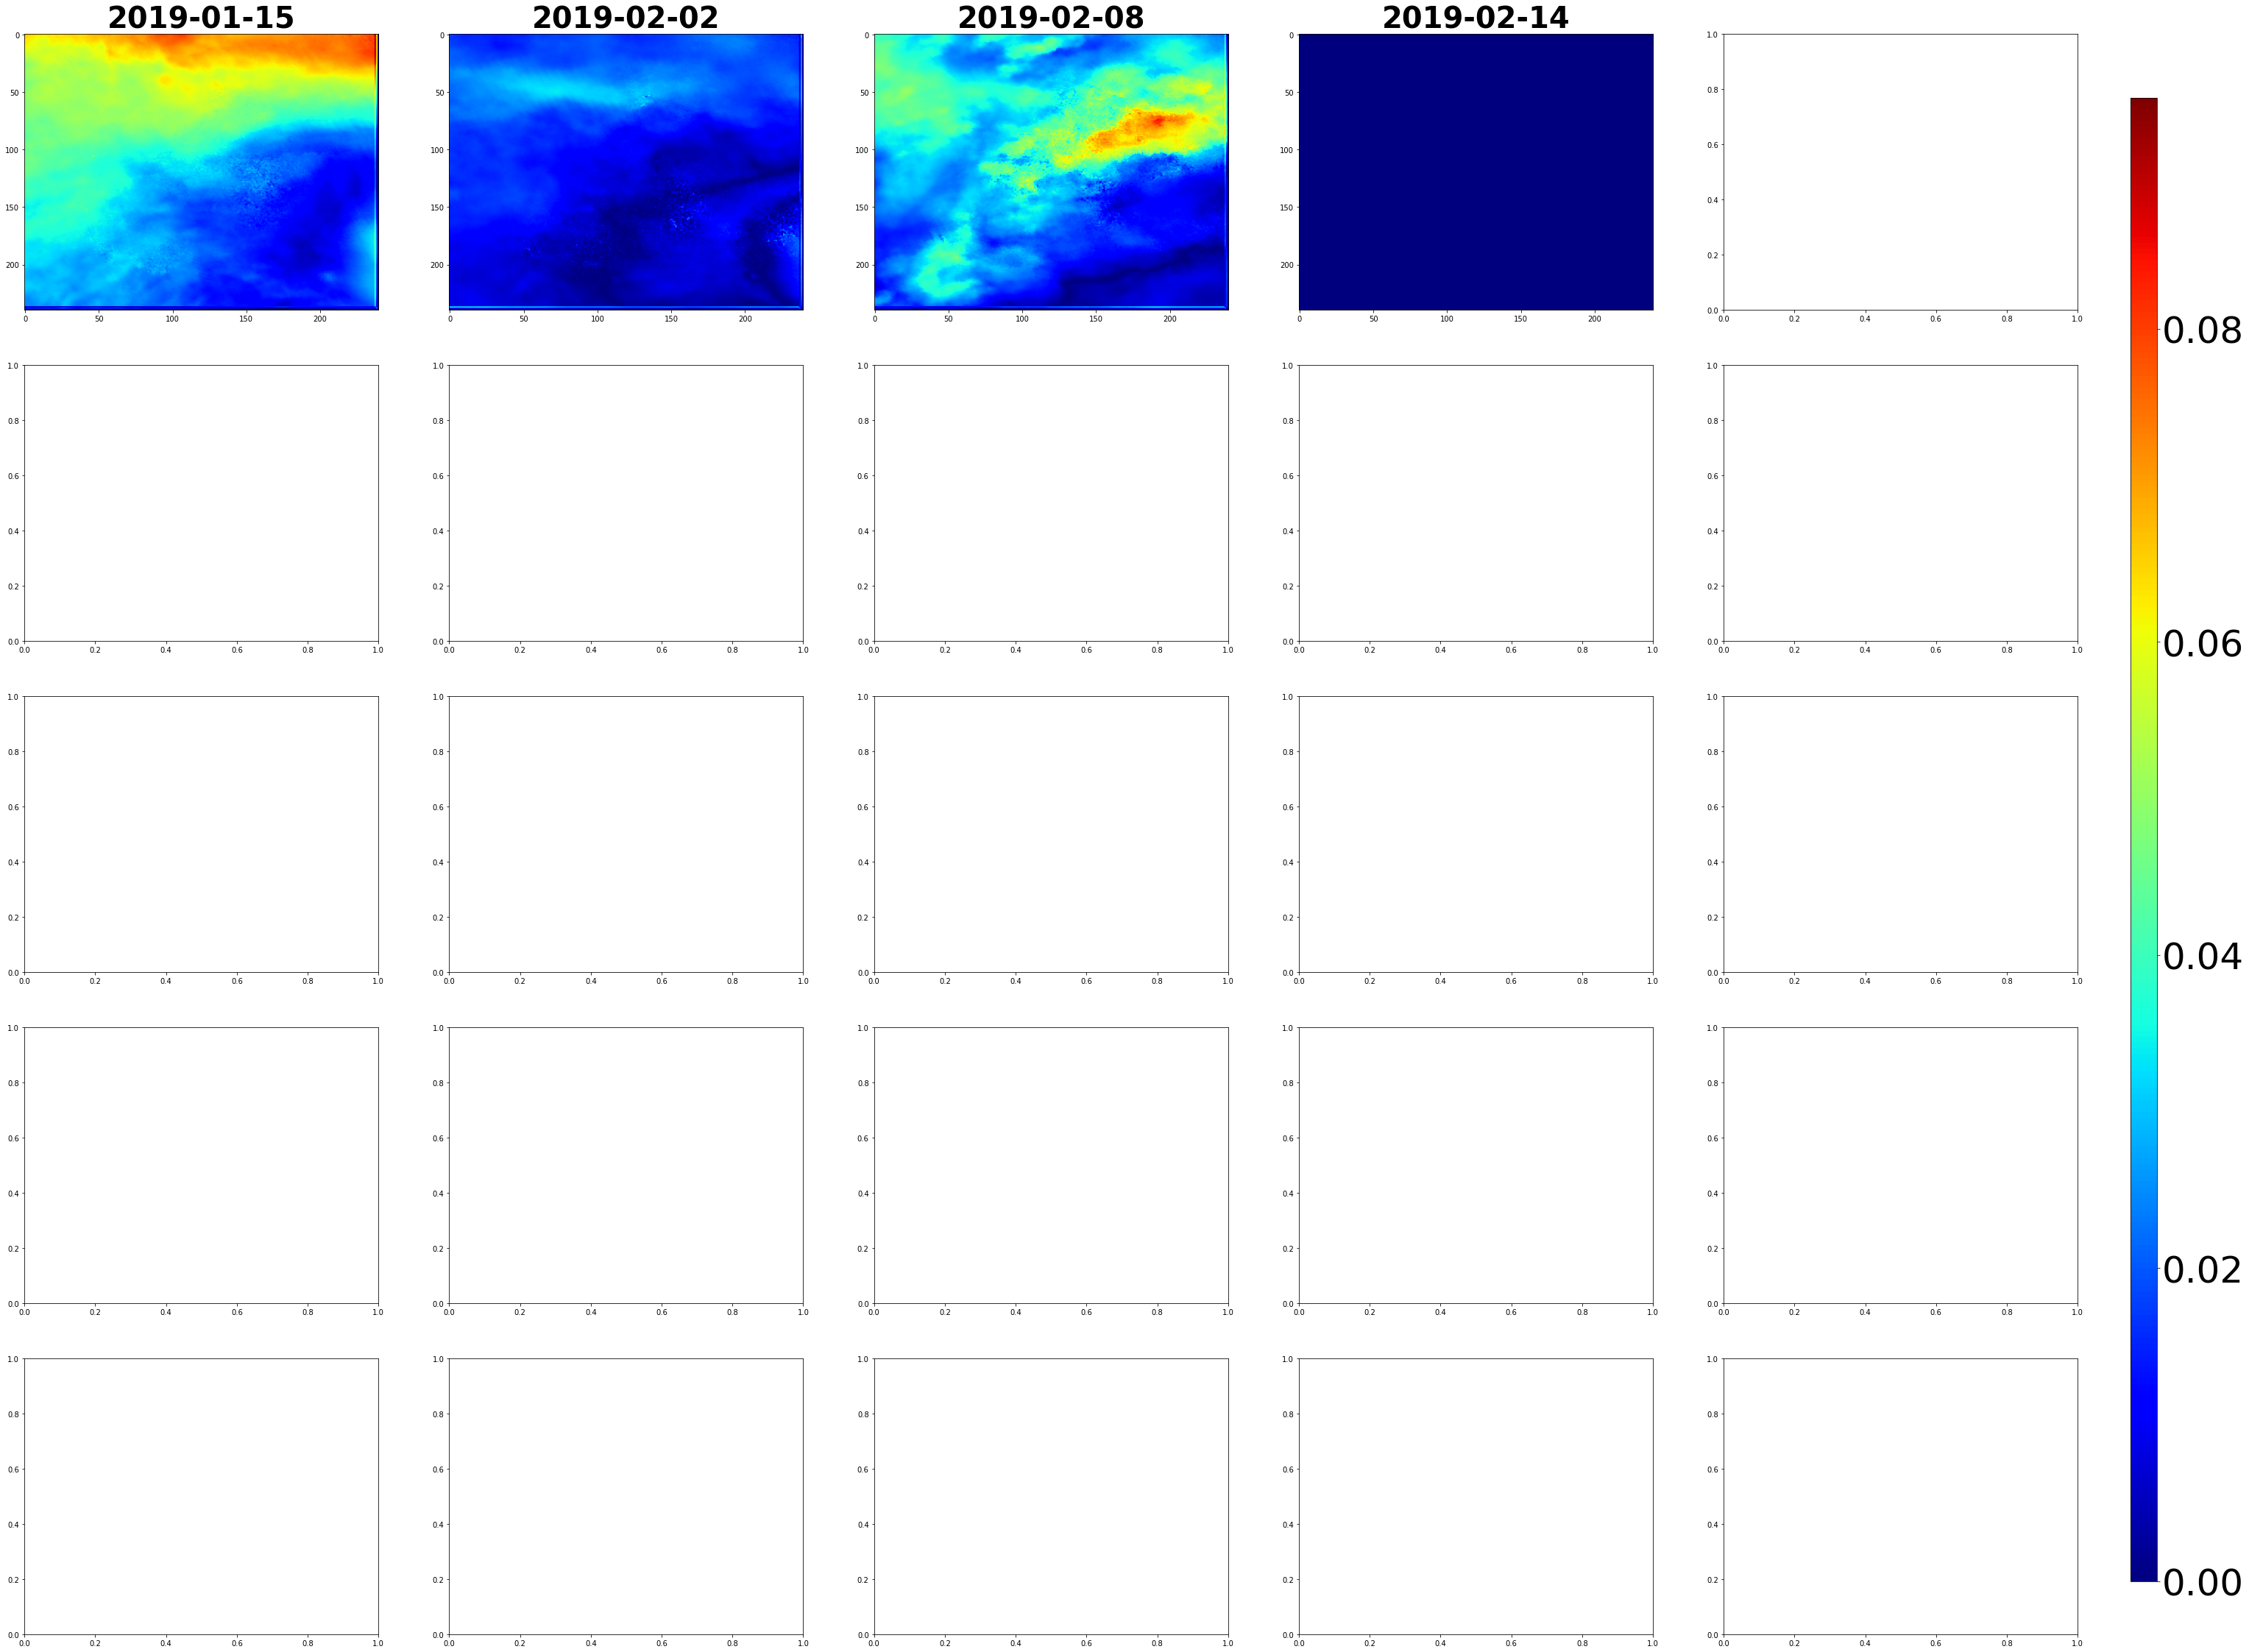

In [6]:
from viz_utils import * 
plot_timeseries2d(anomaly_map, dates[time_window+1:], 'Anomaly Maps', '.')